#### Autoencoder

In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader,TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
learning_rate = 0.005
num_epochs = 5
batch_size = 500

# Architecture
num_features = 784
num_hidden_1 = 100

Device: cpu


In [2]:
# Load data
images = np.load("F:/Fall 2019/stat 479-ML/Project_Group_7/GITHUB/sample_1000_image.npy")
labels = np.load("F:/Fall 2019/stat 479-ML/Project_Group_7/GITHUB/sample_1000_label.npy")

# Normalize image data.  0-255 to 0-1
images = images / 255
df = pd.DataFrame(np.concatenate((images, labels), axis=1))

# Rename the last column as "label"
df.rename(columns={784:"label"}, inplace=True)

# Convert label column to integer type
df['label'] = df['label'].astype('int64')

In [3]:
all_=np.load("F:/Fall 2019/stat 479-ML/Project_Group_7/GITHUB/sample_1000.npy",allow_pickle=True)

In [4]:
img = df.iloc[:, 0:-1]
lbl = df['label']

#Split dataset
x_train1, x_test, y_train1, y_test = train_test_split(img, lbl, test_size = 0.20, random_state = 123, stratify = lbl)
print(x_train1.shape)
print(y_train1.shape)
print(x_test.shape)

(276000, 784)
(276000,)
(69000, 784)


In [5]:
#Convert dataframe to tensor
x_train1 = torch.tensor(x_train1.values)
y_train1 = torch.tensor(y_train1.values)

x_test = torch.tensor(x_test.values)
y_test = torch.tensor(y_test.values)

In [6]:
#Create dataloaders
train_dataset = TensorDataset(x_train1, y_train1)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

In [7]:
# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([256, 784])
Image label dimensions: torch.Size([256])


In [8]:
##########################
### MODEL
##########################

class Autoencoder(torch.nn.Module):

    def __init__(self, num_features):
        super(Autoencoder, self).__init__()
        
        ### ENCODER
        
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        # The following to lones are not necessary, 
        # but used here to demonstrate how to access the weights
        # and use a different weight initialization.
        # By default, PyTorch uses Xavier/Glorot initialization, which
        # should usually be preferred.
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
        ### DECODER
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_features)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        
    def encoder(self, x):
        encoded = self.linear_1(x)
        encoded = F.leaky_relu(encoded)
        return encoded
    
    def decoder(self, encoded_x):
        logits = self.linear_2(encoded_x)
        decoded = torch.sigmoid(logits)
        return decoded
        

    def forward(self, x):
        ### ENCODER
        encoded = self.encoder(x)
        
        ### DECODER
        decoded = self.decoder(encoded)
        
        return decoded

    
torch.manual_seed(random_seed)
model = Autoencoder(num_features=num_features)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
## Training
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = features.view(-1, 28*28).float().to(device)
            
        ### FORWARD AND BACK PROP
        decoded = model(features)
        cost = F.binary_cross_entropy(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/005 | Batch 000/1079 | Cost: 0.7171
Epoch: 001/005 | Batch 050/1079 | Cost: 0.2902
Epoch: 001/005 | Batch 100/1079 | Cost: 0.2329
Epoch: 001/005 | Batch 150/1079 | Cost: 0.2116
Epoch: 001/005 | Batch 200/1079 | Cost: 0.1945
Epoch: 001/005 | Batch 250/1079 | Cost: 0.1873
Epoch: 001/005 | Batch 300/1079 | Cost: 0.1768
Epoch: 001/005 | Batch 350/1079 | Cost: 0.1778
Epoch: 001/005 | Batch 400/1079 | Cost: 0.1728
Epoch: 001/005 | Batch 450/1079 | Cost: 0.1703
Epoch: 001/005 | Batch 500/1079 | Cost: 0.1653
Epoch: 001/005 | Batch 550/1079 | Cost: 0.1638
Epoch: 001/005 | Batch 600/1079 | Cost: 0.1614
Epoch: 001/005 | Batch 650/1079 | Cost: 0.1635
Epoch: 001/005 | Batch 700/1079 | Cost: 0.1662
Epoch: 001/005 | Batch 750/1079 | Cost: 0.1667
Epoch: 001/005 | Batch 800/1079 | Cost: 0.1639
Epoch: 001/005 | Batch 850/1079 | Cost: 0.1601
Epoch: 001/005 | Batch 900/1079 | Cost: 0.1573
Epoch: 001/005 | Batch 950/1079 | Cost: 0.1596
Epoch: 001/005 | Batch 1000/1079 | Cost: 0.1660
Epoch: 001/0

Image batch dimensions: torch.Size([15, 784])
Image label dimensions: torch.Size([15])
Image batch dimensions: torch.Size([15, 784])
Image label dimensions: torch.Size([15])


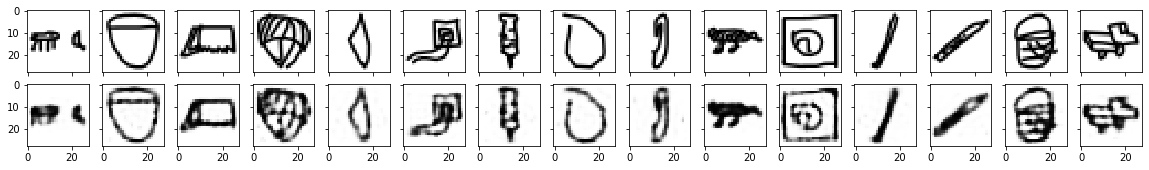

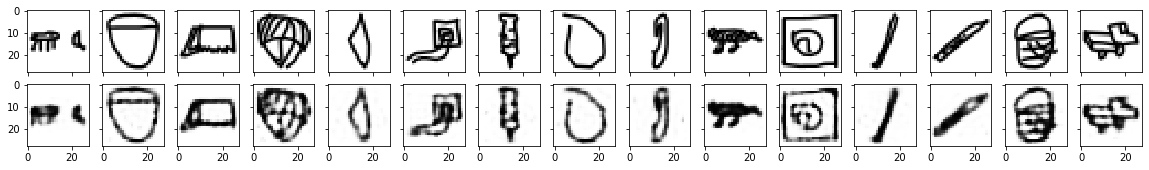

In [10]:
#Evaluation
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=15, 
                          shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
# =============================================================

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')
        
test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=15, 
                         shuffle=True)

# Checking the dataset
for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
# =============================================================

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')


In [11]:
from sklearn.ensemble import RandomForestClassifier


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=60000, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=10000, 
                          shuffle=False)

In [12]:
X_train_compr = np.ones((60000, num_hidden_1))
y_train = np.ones(60000)

start_idx = 0

for idx, (images, labels) in enumerate(train_loader): 
    features = images.view(-1, 28*28).to(device)
    encoded = model.encoder(features)
    X_train_compr[start_idx:start_idx+1000] = encoded.to(torch.device('cpu')).detach().numpy()
    y_train[start_idx:start_idx+1000] = labels
    start_idx += 1000

RuntimeError: Expected object of scalar type Float but got scalar type Double for argument #2 'mat1' in call to _th_addmm

In [ ]:
X_test_compr = np.ones((10000, num_hidden_1))
y_test = np.ones(10000)

start_idx = 0

for idx, (images, labels) in enumerate(test_loader): 
    features = images.view(-1, 28*28).to(device)
    encoded = model.encoder(features)
    X_test_compr[start_idx:start_idx+1000] = encoded.to(torch.device('cpu')).detach().numpy()
    y_test[start_idx:start_idx+1000] = labels
    start_idx += 1000

#### K means

In [40]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
import time
import pandas as pd
from collections import Counter
import ast

In [13]:
#Load data as input 
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=276000, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=69000, 
                          shuffle=False)

In [14]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

X_train = np.array(images.reshape(276000, 28*28))
y_train = np.array(labels)


for images, labels in test_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

X_test = np.array(images.reshape(69000, 28*28))
y_test = np.array(labels)

Image batch dimensions: torch.Size([276000, 784])
Image label dimensions: torch.Size([276000])
Image batch dimensions: torch.Size([69000, 784])
Image label dimensions: torch.Size([69000])


In [15]:
#Concate to get the train and test dataset
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
print(X.shape)
print(y.shape)

(345000, 784)
(345000,)


In [16]:
#Get the string categories from dictionary mapping 
label_map = open(r"F:/Fall 2019/stat 479-ML/Project_Group_7/GITHUB/stat-479-project/DataPrep/label_map.txt")
label_map = ast.literal_eval(label_map.read())

y = list(y.flatten())
y = list(label_map.get(k, "") for k in y)

In [ ]:
#Train K_means
# prediction_ =[]
# distortions_ = []
# t0 = time.time()

# for i in range(0, 345, 50):
#     if i >0:
#         print(i)
#         km = KMeans(init='k-means++', n_clusters=i, n_init=10, max_iter=300)
#         prediction_.append(km.fit_predict(X))
#         distortions_.append(km.inertia_)
    

    
# km = KMeans(init='k-means++', n_clusters=345, n_init=10, max_iter=300)
# prediction_.append(km.fit_predict(X))
# distortions_.append(km.inertia_)
    
# t_mini_batch = time.time() - t0

In [ ]:
# plt.plot(range(0, 345, 30),distortions_, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
# plt.show()

In [44]:
#Train mini batch K_means
prediction =[]
distortions = []
t0 = time.time()

km = MiniBatchKMeans(init='k-means++', n_clusters=1, batch_size=10000, n_init=10, max_iter=300)
prediction.append(km.fit_predict(X))
distortions.append(km.inertia_)


for i in range(0, 345, 50):
    if i >0:
        print(i)
        km = MiniBatchKMeans(init='k-means++', n_clusters=i, batch_size=10000, n_init=10, max_iter=300)
        prediction.append(km.fit_predict(X))
        distortions.append(km.inertia_)
    

    
km = MiniBatchKMeans(init='k-means++', n_clusters=345, batch_size=10000, n_init=10, max_iter=300)
prediction.append(km.fit_predict(X))
distortions.append(km.inertia_)
    
t_mini_batch = time.time() - t0

50
100
150
200
250
300


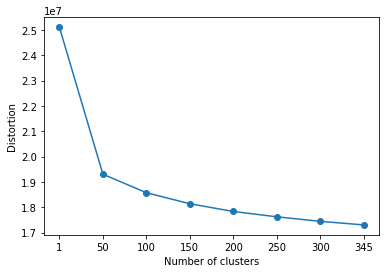

In [55]:
labels = ["1","1", "50", "100", "150","200", "250", "300", "345"]

fig, ax = plt.subplots()
ax.set_xticklabels(labels)

plt.plot(distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [56]:
y_kmeans=list(prediction[3])
y_category = np.array(y)
clusters=set(y_kmeans)
print(clusters) 

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149}


In [57]:
cluster_index = []
for cluster in clusters:
    indices = [i for i, x in enumerate(y_kmeans) if x == cluster]
    cluster_index.append(indices)

In [58]:
category_cluster=[]
for index in cluster_index:
    category_cluster.append(y_category[index]) 

In [59]:
#Check the top 4 categories in each clusters
for new_category in category_cluster:
#     print(new_category)
    c = Counter(new_category)
    print(c.most_common(3))

[('squirrel', 139), ('cow', 124), ('horse', 73)]
[('cello', 96), ('flamingo', 93), ('lightning', 88)]
[('crocodile', 83), ('canoe', 72), ('saw', 70)]
[('skateboard', 174), ('saw', 104), ('mouth', 79)]
[('cello', 184), ('broom', 164), ('shovel', 146)]
[('microwave', 149), ('fireplace', 107), ('bus', 100)]
[('wineglass', 309), ('floorlamp', 277), ('lollipop', 273)]
[('ladder', 165), ('finger', 137), ('skyscraper', 115)]
[('horse', 71), ('zebra', 60), ('tiger', 55)]
[('drill', 201), ('bowtie', 110), ('castle', 87)]
[('shoe', 134), ('crown', 107), ('rollerskates', 82)]
[('mountain', 148), ('tent', 148), ('TheEiffelTower', 119)]
[('sun', 281), ('sweater', 257), ('t-shirt', 227)]
[('baseball', 114), ('wheel', 112), ('donut', 107)]
[('apple', 199), ('compass', 114), ('blueberry', 105)]
[('teddy-bear', 227), ('harp', 101), ('TheMonaLisa', 90)]
[('door', 228), ('cellphone', 169), ('bucket', 159)]
[('rain', 182), ('animalmigration', 170), ('rollercoaster', 128)]
[('mermaid', 98), ('kangaroo', 97

In [60]:
#Check the top 4 categories in each clusters
top_categpry=[]
for new_category in category_cluster:
#     print(new_category)
    c = Counter(new_category)
    top_categpry.append(c.most_common(1))

In [61]:
print(top_categpry)

[[('squirrel', 139)], [('cello', 96)], [('crocodile', 83)], [('skateboard', 174)], [('cello', 184)], [('microwave', 149)], [('wineglass', 309)], [('ladder', 165)], [('horse', 71)], [('drill', 201)], [('shoe', 134)], [('mountain', 148)], [('sun', 281)], [('baseball', 114)], [('apple', 199)], [('teddy-bear', 227)], [('door', 228)], [('rain', 182)], [('mermaid', 98)], [('skyscraper', 153)], [('shark', 184)], [('belt', 170)], [('stereo', 105)], [('TheEiffelTower', 323)], [('pictureframe', 193)], [('lightbulb', 267)], [('bicycle', 107)], [('wheel', 158)], [('tennisracquet', 311)], [('flamingo', 122)], [('stairs', 119)], [('pineapple', 131)], [('bracelet', 98)], [('butterfly', 151)], [('van', 182)], [('matches', 175)], [('snowflake', 151)], [('bicycle', 167)], [('flyingsaucer', 141)], [('beard', 142)], [('suitcase', 133)], [('shorts', 146)], [('waterslide', 141)], [('strawberry', 127)], [('bulldozer', 143)], [('speedboat', 92)], [('keyboard', 209)], [('tornado', 217)], [('stairs', 245)], [('

In [64]:
for item in top_categpry:
    print(item)

[('squirrel', 139)]
[('cello', 96)]
[('crocodile', 83)]
[('skateboard', 174)]
[('cello', 184)]
[('microwave', 149)]
[('wineglass', 309)]
[('ladder', 165)]
[('horse', 71)]
[('drill', 201)]
[('shoe', 134)]
[('mountain', 148)]
[('sun', 281)]
[('baseball', 114)]
[('apple', 199)]
[('teddy-bear', 227)]
[('door', 228)]
[('rain', 182)]
[('mermaid', 98)]
[('skyscraper', 153)]
[('shark', 184)]
[('belt', 170)]
[('stereo', 105)]
[('TheEiffelTower', 323)]
[('pictureframe', 193)]
[('lightbulb', 267)]
[('bicycle', 107)]
[('wheel', 158)]
[('tennisracquet', 311)]
[('flamingo', 122)]
[('stairs', 119)]
[('pineapple', 131)]
[('bracelet', 98)]
[('butterfly', 151)]
[('van', 182)]
[('matches', 175)]
[('snowflake', 151)]
[('bicycle', 167)]
[('flyingsaucer', 141)]
[('beard', 142)]
[('suitcase', 133)]
[('shorts', 146)]
[('waterslide', 141)]
[('strawberry', 127)]
[('bulldozer', 143)]
[('speedboat', 92)]
[('keyboard', 209)]
[('tornado', 217)]
[('stairs', 245)]
[('wineglass', 288)]
[('pear', 404)]
[('spider', 88)]

In [65]:
top_data=pd.read_excel(r"C:/Users/gaoru/Desktop/top_category.xlsx")

In [66]:
for i in range(top_data.shape[0]):
    array = str(top_data["Category"][i]).strip(" ").split(" ")
    top_data["Category"][i]=array [0]
    top_data["Number"][i]=array [1]

C:\Users\gaoru\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\gaoru\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [67]:
top_data.to_excel(r"C:/Users/gaoru/Desktop/top_category_.xlsx") 

In [74]:
top_data=pd.read_excel(r"C:/Users/gaoru/Desktop/top_category_.xlsx")
top_10_number=top_data["Number"][:10]#np.argpartition(top_data["Number"], -10)[-10:]
top_10_category = top_data["Category"][:10]#top_data["Category"][top_10_number]

print(top_10_number)
print(top_10_category)

0    503
1    452
2    452
3    404
4    358
5    337
6    323
7    316
8    311
9    309
Name: Number, dtype: int64
0              line
1        headphones
2           rainbow
3              pear
4          triangle
5           t-shirt
6    TheEiffelTower
7             rifle
8     tennisracquet
9         wineglass
Name: Category, dtype: object


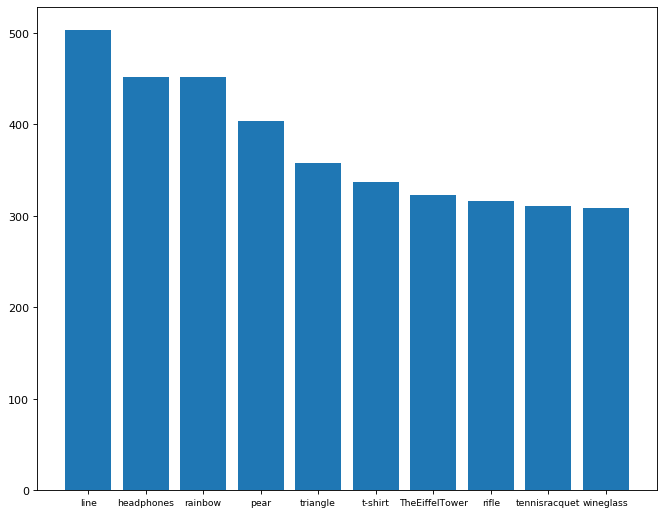

In [75]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

plt.bar(range(len(top_10_number)), top_10_number, align='center')
plt.xticks(range(len(top_10_category)), top_10_category, size='small')

plt.show()